In [1]:
import torch
import torch.nn as nn
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Adapted from https://github.com/A-LinCui/Adversarial_Patch_Attack

weights = ResNet50_Weights.DEFAULT

model = resnet50(weights=weights)

model = model.to(device)
if device == 'cuda':
    model = torch.nn.DataParallel(model)

model = model.eval()

torch.Size([3, 2501, 2501]) torch.Size([1, 3, 224, 224])


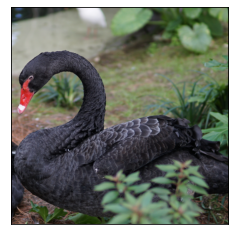

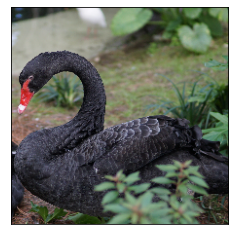

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as T


plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = T.ToPILImage()(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


transform = T.Compose([
    T.Resize((224, 224)),
    T.Normalize(mean=[0, 0, 0], std=[255.0, 255.0, 255.0]),    
])

        
img = read_image('images/black_swan.jpeg')
#img = read_image('images/macaw.jpg')
show([img])
batch = transform(img.float()).unsqueeze(0)
print(img.shape,batch.shape)
show(batch)

In [3]:
batch = batch.to(device)
prediction = model(batch).squeeze(0).softmax(0)

class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
print(f"{category_name}: {100 * score:.1f}%")
print("Top-K labels:",prediction.topk(5)[1].cpu().numpy())


black swan: 44.3%
Top-K labels: [100  99  80   8  22]


In [4]:
import numpy as np
from torch.autograd import Variable

def patch_initialization(patch_type='rectangle', image_size=(3, 224, 224), noise_percentage=0.03):
    if patch_type == 'rectangle':
        mask_length = int((noise_percentage * image_size[1] * image_size[2])**0.5)
        patch = np.random.rand(image_size[0], mask_length, mask_length)
    return patch


# Generate the mask and apply the patch
# TODO: Add circle type
def mask_generation(mask_type='rectangle', patch=None, image_size=(3, 224, 224)):
    applied_patch = np.zeros(image_size)
    if mask_type == 'rectangle':
        # patch rotation
        rotation_angle = np.random.choice(4)
        for i in range(patch.shape[0]):
            patch[i] = np.rot90(patch[i], rotation_angle)  # The actual rotation angle is rotation_angle * 90
        # patch location
        x_location, y_location = np.random.randint(low=0, high=image_size[1]-patch.shape[1]), np.random.randint(low=0, high=image_size[2]-patch.shape[2])
        for i in range(patch.shape[0]):
            applied_patch[:, x_location:x_location + patch.shape[1], y_location:y_location + patch.shape[2]] = patch
    mask = applied_patch.copy()
    mask[mask != 0] = 1.0
    return applied_patch, mask, x_location, y_location



def patch_attack(image, applied_patch, mask, target, probability_threshold, model, lr=1, max_iteration=100):
    model.eval()
    applied_patch = torch.from_numpy(applied_patch)
    mask = torch.from_numpy(mask)
    target_probability, count = 0, 0
    perturbated_image = torch.mul(mask.type(torch.FloatTensor), applied_patch.type(torch.FloatTensor)) + torch.mul((1 - mask.type(torch.FloatTensor)), image.type(torch.FloatTensor))
    while target_probability < probability_threshold and count < max_iteration:
        count += 1
        # Optimize the patch
        perturbated_image = Variable(perturbated_image.data, requires_grad=True)
        per_image = perturbated_image
        per_image = per_image.cuda()
        output = model(per_image)
        target_log_softmax = torch.nn.functional.log_softmax(output, dim=1)[0][target]
        target_log_softmax.backward()
        patch_grad = perturbated_image.grad.clone().cpu()
        perturbated_image.grad.data.zero_()
        applied_patch = lr * patch_grad + applied_patch.type(torch.FloatTensor)
        applied_patch = torch.clamp(applied_patch, min=-3, max=3)
        # Test the patch
        perturbated_image = torch.mul(mask.type(torch.FloatTensor), applied_patch.type(torch.FloatTensor)) + torch.mul((1-mask.type(torch.FloatTensor)), image.type(torch.FloatTensor))
        perturbated_image = torch.clamp(perturbated_image, min=-3, max=3)
        perturbated_image = perturbated_image.cuda()
        output = model(perturbated_image)
        target_probability = torch.nn.functional.softmax(output, dim=1).data[0][target]
    perturbated_image = perturbated_image.cpu().numpy()
    applied_patch = applied_patch.cpu().numpy()
    return perturbated_image, applied_patch



target = 859
probability_threshold = 0.9
noise_percentage = 0.1
lr = 1.0
max_iteration=1000
patch_type = 'rectangle'
patch = patch_initialization(patch_type, image_size=(3, 224, 224), noise_percentage=noise_percentage)
print('The shape of the patch is', patch.shape)
applied_patch, mask, x_location, y_location = mask_generation(patch_type, patch, image_size=(3, 224, 224))
print(patch.shape,applied_patch.shape)
perturbated_image, applied_patch = patch_attack(batch, applied_patch, mask, target, probability_threshold, model, lr, max_iteration)


The shape of the patch is (3, 70, 70)
(3, 70, 70) (3, 224, 224)


In [5]:
prediction = model(torch.from_numpy(perturbated_image)).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]


Attacked Label: toaster 90.1%


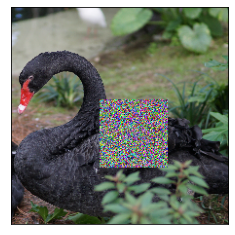

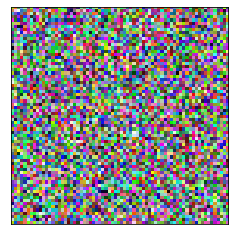

In [6]:
print("Attacked Label: "f"{category_name} {100 * score:.1f}%")
show(torch.from_numpy(perturbated_image))
show([torch.from_numpy(patch)])
